In [ ]:
import dill
import struct
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# 用于适配interview接口
class MNIST_Net(Net):
    @staticmethod
    def image_data(file_name):
        with open(file_name, "rb") as f:
            buffer = f.read(16)
            magic, num, rows, cols = struct.unpack(">iiii", buffer)
            buffer = f.read(rows * cols * num)
            data = np.frombuffer(buffer, dtype=np.uint8)
            data = data.reshape(num, rows, cols)
        return data

    @staticmethod
    def label_data(file_name):
        with open(file_name, "rb") as f:
            buffer = f.read(8)
            magic, num = struct.unpack(">ii", buffer)
            buffer = f.read(num)
            data = np.frombuffer(buffer, dtype=np.uint8)
            data = data.reshape(num, 1)
        return data

    @staticmethod
    def one_hot(labels, num_classes):
        one_hot_labels = np.zeros((len(labels), num_classes))
        for i in range(len(labels)):
            one_hot_labels[i, labels[i]] = 1
        return one_hot_labels

    def interview(self, eval_datafile_path):
        eval_images = self.image_data(eval_datafile_path[0])
        eval_labels = self.label_data(eval_datafile_path[1])
        eval_labels = self.one_hot(eval_labels, 10)
        _eval_labels = self.pred(eval_images)
        return np.mean(np.argmax(eval_labels, axis=1) == np.argmax(_eval_labels, axis=1)) * 100

(60000, 28, 28) (60000, 1)


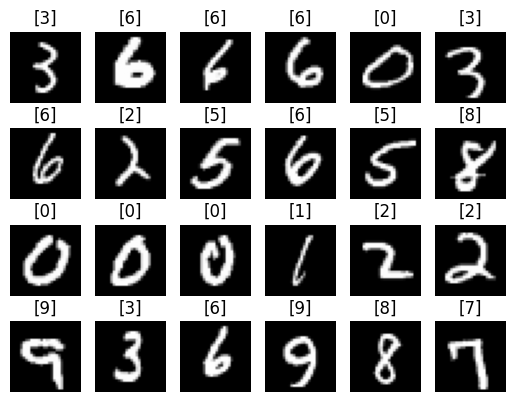

In [3]:
# 读取文件数据
images = MNIST_Net.image_data("mnist_testdata/train-images.idx3-ubyte")
labels = MNIST_Net.label_data("mnist_testdata/train-labels.idx1-ubyte")
print(images.shape, labels.shape)

# 随机打乱数据
np.random.seed(0)
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")
plt.show()

In [4]:
# 分割训练集与验证集 (4:1)
split = int(len(images) * 0.8)
train_images, valid_images = images[:split], images[split:]
train_labels, valid_labels = labels[:split], labels[split:]

In [5]:
# 添加图片通道
height, width = images.shape[1], images.shape[2]
train_images = train_images.reshape(train_images.shape[0], 1, height, width)
valid_images = valid_images.reshape(valid_images.shape[0], 1, height, width)

# 独热标签数据
train_labels = MNIST_Net.one_hot(train_labels, 10)
valid_labels = MNIST_Net.one_hot(valid_labels, 10)

print(train_images.shape, valid_images.shape)
print(train_labels.shape, valid_labels.shape)

(48000, 1, 28, 28) (12000, 1, 28, 28)
(48000, 10) (12000, 10)


In [6]:
def shuffle_data(images, labels):
    np.random.seed(0)
    indices = np.random.permutation(len(images))
    return images[indices], labels[indices]

In [ ]:

net_info = [
    # (1, 28, 28) -> (2, 20, 20)
    {"module": Conv2d, "param": {"in_channels": 1, "out_channels": 2, "kernel_size": 9}},
    {"module": Gelu},
    {"module": Flatten},
    {"module": Mlp, "param": {"in_features": 800, "out_features": 256}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.2}},
    {"module": Mlp, "param": {"in_features": 256, "out_features": 10}},
    {"module": Softmax},
]

net = MNIST_Net(net_info, 2)

In [14]:
record = []
epochs = 10

for i in range(epochs):
    train_images, train_labels = shuffle_data(train_images, train_labels)
    net.train(train_images, train_labels, CrossEntropy, 1000, 1)

    _train_labels = net.pred(train_images)
    _valid_labels = net.pred(valid_images)
    _train_loss = CrossEntropy.forward(train_labels, _train_labels) * 100
    _valid_loss = CrossEntropy.forward(valid_labels, _valid_labels) * 100

    _valid_accuracy = np.mean(np.argmax(_valid_labels, axis=1) == np.argmax(valid_labels, axis=1)) * 100
    print(f"Epoch: {i}, Train Loss: {_train_loss:.4f}, Valid Loss: {_valid_loss:.4f}, Valid Accuracy: {_valid_accuracy:.2f}%")
    record.append([_train_loss, _valid_loss, _valid_accuracy])

Epoch: 0, Train Loss: 5.4074, Valid Loss: 7.6813, Valid Accuracy: 97.82%
Epoch: 1, Train Loss: 5.3644, Valid Loss: 7.6333, Valid Accuracy: 97.88%
Epoch: 2, Train Loss: 5.3132, Valid Loss: 7.6254, Valid Accuracy: 97.82%
Epoch: 3, Train Loss: 5.3182, Valid Loss: 7.6538, Valid Accuracy: 97.84%
Epoch: 4, Train Loss: 5.2430, Valid Loss: 7.5784, Valid Accuracy: 97.88%
Epoch: 5, Train Loss: 5.1737, Valid Loss: 7.5013, Valid Accuracy: 97.87%
Epoch: 6, Train Loss: 5.1730, Valid Loss: 7.6003, Valid Accuracy: 97.83%
Epoch: 7, Train Loss: 5.0822, Valid Loss: 7.5024, Valid Accuracy: 97.84%
Epoch: 8, Train Loss: 5.0398, Valid Loss: 7.4039, Valid Accuracy: 97.90%
Epoch: 9, Train Loss: 4.9922, Valid Loss: 7.4537, Valid Accuracy: 97.86%


In [15]:
with open("task2-mnist-my.pickle", "wb") as f:
    dill.dump(net, f)

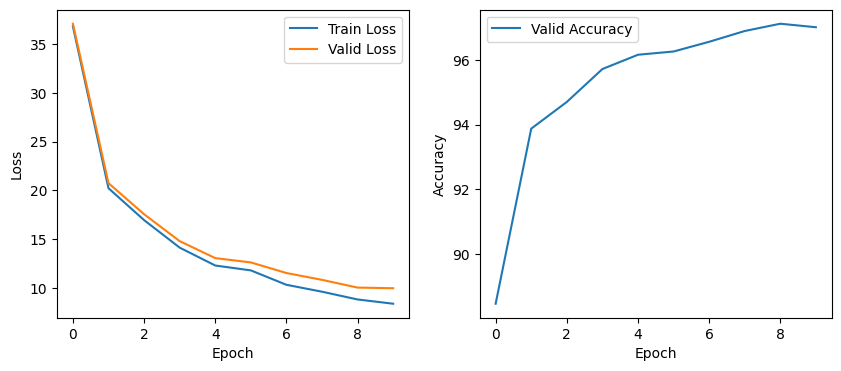

In [10]:
# 绘制训练曲线
# 图1: 训练损失与验证损失
# 图2: 验证准确率
record = np.array(record)
record = np.array(record)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(record[:, 0], label="Train Loss")
plt.plot(record[:, 1], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(record[:, 2], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


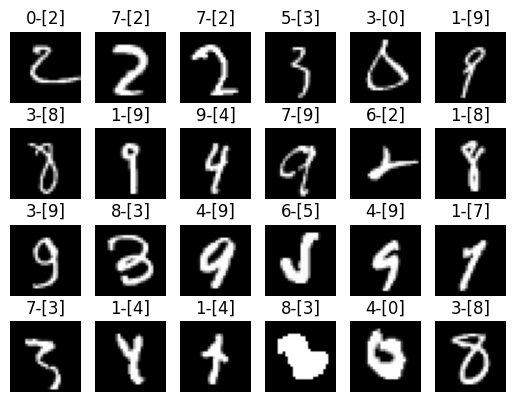

In [11]:
# 打印识别失败的图片
_valid_labels = net.pred(valid_images)
indices = np.argmax(_valid_labels, axis=1) != np.argmax(valid_labels, axis=1)
indices = np.random.permutation(np.where(indices)[0])


# 标题为 (预测-准确)
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(valid_images[indices][i].reshape(28, 28), cmap="gray")
    plt.title(f"{np.argmax(_valid_labels[indices][i])}-[{np.argmax(valid_labels[indices][i])}]")
    plt.axis("off")
plt.show()